In [5]:
from configs import API_KEY, DEFAULT_MODEL
import os
import openai
from langgraph.graph import START, END, StateGraph, add_messages,MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage,HumanMessage, BaseMessage
from langchain_core.runnables import Runnable 
from collections.abc import Sequence
from typing import Literal, Annotated

In [6]:
os.environ["OPENAI_API_KEY"] = API_KEY
openai.api_key = os.getenv('OPENAI_API_KEY')

In [7]:
my_list = add_messages([HumanMessage("Hi! I am Aniket"),
                        AIMessage("Hi Aniket, how may I assist you today?")],
                       [HumanMessage("Could you summarize today's news?")])

In [8]:
my_list

[HumanMessage(content='Hi! I am Aniket', additional_kwargs={}, response_metadata={}, id='b1aed932-48ee-4bbf-a163-0e24447ea115'),
 AIMessage(content='Hi Aniket, how may I assist you today?', additional_kwargs={}, response_metadata={}, id='ab24bd2b-fa42-48e4-aeb4-eded48cbd9fe', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="Could you summarize today's news?", additional_kwargs={}, response_metadata={}, id='0c9c83fa-be2b-48f1-b148-d565709d5066')]

In [9]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] ##Annotated lets you attach a metadata to a type

# Here, when State Graph updates a field, it will use add_messages() to merge old and new values, rather than overwriting

add_messages is a Reducer function, It helps in combining the current state with the new incoming data in a structured way

In [10]:
chat = ChatOpenAI(model='gpt-4',
                 seed = 365,
                 temperature = 0,
                 max_completion_tokens = 100)

In [11]:
def ask_question(state: State) -> State:
    print("\n--------------> Entering Ask Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "What is your question?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: State) -> State:
    print("\n--------------> Entering Chatbot:")
    
    for i in state["messages"]:
        i.pretty_print()
    response = chat.invoke(state['messages'])
    response.pretty_print()
    return State(messages=[response])
    
def ask_another_question(state: State) -> State:
    print("\n--------------> Entering Ask Another Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

In [12]:
def routing_function(state: State) -> Literal["ask_question","__end__"] :
    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

In [13]:
graph = StateGraph(State)
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function,)

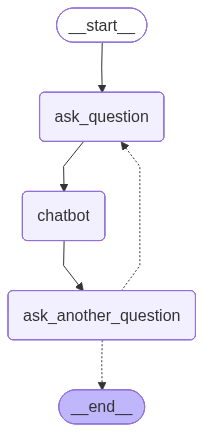

In [14]:
graph_compiled = graph.compile()
graph_compiled

In [15]:
graph_compiled.invoke(State(messages=[]))


--------------> Entering Ask Question Node:
What is your question?


 who is Trump?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who is Trump?
================================== Ai Message ==================================

Donald John Trump is an American businessman, television personality, and politician who served as the 45th president of the United States from January 20, 2017, to January 20, 2021. Before entering politics, he was a businessman and television personality, known for hosting the reality TV show, "The Apprentice." Trump was born on June 14, 1946, in Queens, New York City, and earned an economics degree from the Wharton School of the University of

--------------> Entering Ask Another Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message ===========================

 no


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='ec653d9e-2933-4062-ab06-7eab22035198', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='who is Trump?', additional_kwargs={}, response_metadata={}, id='19884331-a0a5-4d4c-8252-bcef48a71404'),
  AIMessage(content='Donald John Trump is an American businessman, television personality, and politician who served as the 45th president of the United States from January 20, 2017, to January 20, 2021. Before entering politics, he was a businessman and television personality, known for hosting the reality TV show, "The Apprentice." Trump was born on June 14, 1946, in Queens, New York City, and earned an economics degree from the Wharton School of the University of', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 20, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_token

## MessagesState class

In [16]:
def ask_question(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Ask Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "What is your question?"
    print(question)
    return MessagesState(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Chatbot:")
    
    for i in state["messages"]:
        i.pretty_print()
    response = chat.invoke(state['messages'])
    response.pretty_print()
    return MessagesState(messages=[response])
    
def ask_another_question(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Ask Another Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    return MessagesState(messages=[AIMessage(question), HumanMessage(input())])

In [17]:
def routing_function(state: MessagesState) -> Literal["ask_question","__end__"] :
    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

In [18]:
graph_ms = StateGraph(MessagesState)
graph_ms.add_node("ask_question", ask_question)
graph_ms.add_node("chatbot", chatbot)
graph_ms.add_node("ask_another_question", ask_another_question)

graph_ms.add_edge(START, "ask_question")
graph_ms.add_edge("ask_question", "chatbot")
graph_ms.add_edge("chatbot", "ask_another_question")
graph_ms.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function,)

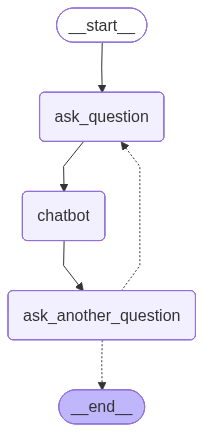

In [19]:
graph_ms_compiled = graph_ms.compile()
graph_ms_compiled

In [20]:
graph_ms_compiled.invoke(State(messages=[]))


--------------> Entering Ask Question Node:
What is your question?


 when did Titanic release?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

when did Titanic release?
================================== Ai Message ==================================

The movie "Titanic" was released on December 19, 1997 in the United States.

--------------> Entering Ask Another Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

when did Titanic release?
================================== Ai Message ==================================

The movie "Titanic" was released on December 19, 1997 in the United States.
Would you like to ask one more question (yes/no)?


 yes



--------------> Entering Ask Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

when did Titanic release?
================================== Ai Message ==================================

The movie "Titanic" was released on December 19, 1997 in the United States.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What is your question?


 who played the main character?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

when did Titanic release?
================================== Ai Message ==================================

The movie "Titanic" was released on December 19, 1997 in the United States.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who played the main character?
================================== Ai Message ==================================

The main characters in the movie "Titanic" were played by Leonardo DiCaprio 

 no


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='08e3d196-dfd3-4507-9f80-e346cb5021bd', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='when did Titanic release?', additional_kwargs={}, response_metadata={}, id='60b0271f-2b4c-4f05-a417-29eb366caa1e'),
  AIMessage(content='The movie "Titanic" was released on December 19, 1997 in the United States.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 21, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-D77FfSyW4KUxg30c42m7KnVGEpP35', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c3f4d-18c2-7863